In [2]:
from git import Repo, GitCommandError

import pandas as pd
import os

In [3]:
path_to_data = os.path.join("C:\\Users\\tobias.lindenbauer\\PycharmProjects\\vcs-actions-agent\\", 'data')
path_to_repositories = os.path.join("C:\\Users\\tobias.lindenbauer\\PycharmProjects\\vcs-actions-agent\\", 'repos')

# Qualitative analysis of metadata

## Python

In [22]:
# 1. Read in repositories from CSV
python_repositories_metadata = pd.read_csv(os.path.join(path_to_data, 'python_repos.csv'))

In [23]:
len(python_repositories_metadata)

10246

Let's take a look at the distribution of relevant numeric columns to get an overview of the dataset.

In [5]:
python_repositories_metadata

In [13]:
python_repositories_metadata[['branches', 'releases', 'forks', 'watchers', 'contributors', 'codeLines']].describe()

All repositories include more than one branch. Most include some forks. Curiously, we note that `min(codeLines) = 1`. Looking at the mean and 25% quartile though, we see that overall the repos seem to be in a good shape.

In [6]:
python_repositories_metadata[python_repositories_metadata.codeLines < 2]

In [5]:
pd.to_datetime(python_repositories_metadata.updatedAt).describe()

In [14]:
pd.to_datetime(python_repositories_metadata.createdAt).describe()

## Java

In [24]:
# 1. Read in repositories from CSV
java_repositories_metadata = pd.read_csv(os.path.join(path_to_data, 'java_repos.csv'))

In [25]:
len(java_repositories_metadata)

6840

In [18]:
java_repositories_metadata[['branches', 'releases', 'forks', 'watchers', 'contributors', 'codeLines']].describe()

Most have been forked. Again, we note that `min(codeLines) = 2`. Looking at the mean and 25% quartile though, we see that overall the repos seem to be in a good shape.

In [19]:
pd.to_datetime(java_repositories_metadata.updatedAt).describe()

In [20]:
pd.to_datetime(java_repositories_metadata.createdAt).describe()

## Kotlin

In [26]:
# 1. Read in repositories from CSV
kotlin_repositories_metadata = pd.read_csv(os.path.join(path_to_data, 'kotlin_repos.csv'))

In [27]:
len(kotlin_repositories_metadata)

1704

In [23]:
kotlin_repositories_metadata[['branches', 'releases', 'forks', 'watchers', 'contributors', 'codeLines']].describe()

Most have been forked. Again, we note that `min(codeLines) = 1`. Looking at the mean and 25% quartile though, we see that overall the repos seem to be in a good shape. For Kotlin, we note that the number of contributors and branches seems lower in general.

In [24]:
pd.to_datetime(kotlin_repositories_metadata.updatedAt).describe()

In [25]:
pd.to_datetime(kotlin_repositories_metadata.createdAt).describe()

# Development of git history traversal and quantitative analysis of repositories

## Determine ratio of branches to files

In [14]:
import re 

In [21]:
repositories_statistics = pd.DataFrame()

for i, repository_metadata in python_repositories_metadata.iloc[:15].iterrows():
    repo_instance = None
    repository_path = os.path.join(path_to_repositories, "__".join(repository_metadata["name"].split("/")))
    try:
        repo_instance = Repo.clone_from(f'https://github.com/{repository_metadata["name"]}.git',
                                    f'{repository_path}')
    except GitCommandError as e:
        # If already exists, create Repo instance of it
        if 'already exists' in e.stderr:
            print('Repository already exists, using local directory instead of cloning.')
            repo_instance = Repo(repository_path)
            
    if repo_instance is None:
        continue

    os.chdir(os.path.join(path_to_data, repository_path))

    repositories_statistics.loc[i, 'branches'] = len(repo_instance.refs)
    
    num_python_files = 0
    num_total_files = 0
    for directory,subdirs,files in os.walk(repository_path):
        if re.match('.*(\\\\|\/)\..*', directory):
            continue # Skip hidden folders
        
        python_files = [f for f in files if '.py' in f]
        total_files = [f for f in files if re.match('^[^\.].*\..*$', f)] # skip hidden files and files without file ending
        
        num_python_files += len(python_files)
        num_total_files += len(total_files)

    repositories_statistics.loc[i, 'python_files'] = num_python_files
    repositories_statistics.loc[i, 'total_files'] = num_total_files

In [25]:
(repositories_statistics.total_files / repositories_statistics.branches).sum() / 10

# Exploring results

In [1]:
results = pd.read_parquet(os.path.join(path_to_data, 'kotlin.parquet'), engine='pyarrow')

NameError: name 'pd' is not defined

In [ ]:
results.info()

## Duplicate cherry pick scenarios

In [85]:
cherry_pick_data= results['scraped_data'].apply(lambda x: x['cherry_pick_scenarios'])

In [86]:
cherry_pick_data

1    [{'cherry_commit': 'f7dbb2fc3be3060b29345f7801...
Name: scraped_data, dtype: object

In [87]:
# Need to check cherry pick scenarios at the end of the list.
# Check if I find a scenario with exactly the same commit hexshas another time (duplicated).
scenarios = cherry_pick_data[1]
unpacked_commits = pd.DataFrame()
for i, scenario in enumerate(scenarios):
    unpacked_commits.loc[i, 'cherry_pick_commits'] = scenario['cherry_pick_commit']
    unpacked_commits.loc[i, 'cherry_commits'] = scenario['cherry_commit']

In [88]:
unpacked_commits[unpacked_commits.duplicated(subset=['cherry_pick_commits'], keep=False)]

,cherry_pick_commits,cherry_commits
1,1740abbce2ac0fee408fbdf22ab96405f3468485,e8aaa7dcceab7db818720445e497f98f97c5d6e3
3,1740abbce2ac0fee408fbdf22ab96405f3468485,ef75f21d13699affb9d53f96de06687847027e4d
4,eec22630b7b3d58956a2adbf8eb6a7a2a49326e6,041b8028c66941ad586e3c2ade99164a6d771fb6
6,eec22630b7b3d58956a2adbf8eb6a7a2a49326e6,248d33b15e19660ed744d68295365f203ffe4510
7,a8227756e7cfa6355c0a390f69be8c379d7a6d6c,15acc8349a2c124b07d196c9c26781da9029a8f4
9,a8227756e7cfa6355c0a390f69be8c379d7a6d6c,002421281b7fc6f915a33d21bea85498f42a17b9
10,7b99d889476790950c477c30456aa86e0f1f348d,a7ba3269507d4261aff7d23a7241c337d511b7f0
12,7b99d889476790950c477c30456aa86e0f1f348d,f1136b08663e62552e3704845eabe741d762374e
13,f1446d3b22ae8d21853d1e921d9fa814647b94c4,2fbace0aad729045bbff494bd231cb9bb9da5ef7
15,f1446d3b22ae8d21853d1e921d9fa814647b94c4,9928b4e7f6fe8c6943ee19eff6cf583a09163007


In [37]:
len(cherry_pick_data[1])

447

In [41]:
repository_metadata = python_repositories_metadata.iloc[1]
repo_instance = None
repository_path = os.path.join(path_to_repositories, "__".join(repository_metadata["name"].split("/")))
try:
    repo_instance = Repo.clone_from(f'https://github.com/{repository_metadata["name"]}.git',
                                    f'{repository_path}')
except GitCommandError as e:
    # If already exists, create Repo instance of it
    if 'already exists' in e.stderr:
        print('Repository already exists, using local directory instead of cloning.')
        repo_instance = Repo(repository_path)

Repository already exists, using local directory instead of cloning.


In [99]:
from datetime import datetime
datetime.fromtimestamp(repo_instance.commit('1740abbce2ac0fee408fbdf22ab96405f3468485').committed_date)

datetime.datetime(2020, 9, 23, 0, 26, 24)

In [100]:
datetime.fromtimestamp(repo_instance.commit('e8aaa7dcceab7db818720445e497f98f97c5d6e3').committed_date)

datetime.datetime(2020, 9, 15, 17, 20, 48)

In [101]:
datetime.fromtimestamp(repo_instance.commit('ef75f21d13699affb9d53f96de06687847027e4d').committed_date)


datetime.datetime(2020, 9, 21, 18, 37, 59)

In [93]:
repo_instance.git.show('1740abbce2ac0fee408fbdf22ab96405f3468485').split('\n')

['commit 1740abbce2ac0fee408fbdf22ab96405f3468485',
 'Author: Yoann Padioleau <pad@returntocorp.com>',
 'Date:   Tue Sep 15 17:20:48 2020 +0200',
 '',
 '    * python/lang/correctness/common-mistakes/is-comparison-string.py: Fix (#861)',
 '    ',
 '    * * python/lang/correctness/common-mistakes/is-comparison-string.py: Fix',
 '    ',
 "    Add extra assign to not make 'x' a constant.",
 '    Indeed, Iago recently fixed a bug in the const-analysis which',
 '    now kick-in in this file and leads to more reported errors.',
 '    ',
 '    Related to https://github.com/returntocorp/semgrep/pull/1676',
 '    ',
 '    Test plan:',
 '    make test with latest semgrep',
 '    ',
 '    * Avoid constant propagation by using object() instead of str',
 '    ',
 '    Co-authored-by: Matt Schwager <matt@returntocorp.com>',
 '',
 'diff --git a/python/lang/correctness/common-mistakes/is-comparison-string.py b/python/lang/correctness/common-mistakes/is-comparison-string.py',
 'index 9fb45823..dbb76cf4 

In [92]:
repo_instance.git.show('e8aaa7dcceab7db818720445e497f98f97c5d6e3').split('\n')

['commit e8aaa7dcceab7db818720445e497f98f97c5d6e3',
 'Author: Yoann Padioleau <pad@returntocorp.com>',
 'Date:   Tue Sep 15 17:20:48 2020 +0200',
 '',
 '    * python/lang/correctness/common-mistakes/is-comparison-string.py: Fix (#861)',
 '    ',
 '    * * python/lang/correctness/common-mistakes/is-comparison-string.py: Fix',
 '    ',
 "    Add extra assign to not make 'x' a constant.",
 '    Indeed, Iago recently fixed a bug in the const-analysis which',
 '    now kick-in in this file and leads to more reported errors.',
 '    ',
 '    Related to https://github.com/returntocorp/semgrep/pull/1676',
 '    ',
 '    Test plan:',
 '    make test with latest semgrep',
 '    ',
 '    * Avoid constant propagation by using object() instead of str',
 '    ',
 '    Co-authored-by: Matt Schwager <matt@returntocorp.com>',
 '',
 'diff --git a/python/lang/correctness/common-mistakes/is-comparison-string.py b/python/lang/correctness/common-mistakes/is-comparison-string.py',
 'index 9fb45823..dbb76cf4 

In [94]:
repo_instance.git.show('ef75f21d13699affb9d53f96de06687847027e4d').split('\n')

['commit ef75f21d13699affb9d53f96de06687847027e4d',
 'Author: Yoann Padioleau <pad@returntocorp.com>',
 'Date:   Tue Sep 15 17:20:48 2020 +0200',
 '',
 '    * python/lang/correctness/common-mistakes/is-comparison-string.py: Fix (#861)',
 '    ',
 '    * * python/lang/correctness/common-mistakes/is-comparison-string.py: Fix',
 '    ',
 "    Add extra assign to not make 'x' a constant.",
 '    Indeed, Iago recently fixed a bug in the const-analysis which',
 '    now kick-in in this file and leads to more reported errors.',
 '    ',
 '    Related to https://github.com/returntocorp/semgrep/pull/1676',
 '    ',
 '    Test plan:',
 '    make test with latest semgrep',
 '    ',
 '    * Avoid constant propagation by using object() instead of str',
 '    ',
 '    Co-authored-by: Matt Schwager <matt@returntocorp.com>',
 '',
 'diff --git a/python/lang/correctness/common-mistakes/is-comparison-string.py b/python/lang/correctness/common-mistakes/is-comparison-string.py',
 'index 9fb45823..dbb76cf4 

## Concurrency

In [34]:
results = pd.read_parquet(os.path.join(path_to_data, 'python_small_subset.parquet'), engine='pyarrow')

In [35]:
results

,id,name,isFork,commits,branches,releases,forks,mainLanguage,defaultBranch,license,...,isDisabled,isLocked,languages,labels,topics,scraped_data,n_merge_scenarios,n_cherry_pick_scenarios,n_merge_scenarios_with_resolved_conflicts,n_file_commit_gram_scenarios
0,144686,familysearch/gedcom,False,524,15,15,18,Python,main,Apache License 2.0,...,False,False,"{""Python"":33573,""CSS"":7276,""HTML"":1790,""Makefi...",ambiguity;automated pr;awaiting use;backlog;ci...,None,{'cherry_pick_scenarios': [{'cherry_commit': '...,137,1,1,1
3,3279097,academysoftwarefoundation/opencue,False,780,8,25,191,Python,master,Apache License 2.0,...,False,False,"{""Python"":3395437,""Java"":2368879,""PLpgSQL"":138...",bug;dependencies;docs;duplicate;enhancement;fe...,animation;fx;opencue;openqueue;render;render-f...,{'cherry_pick_scenarios': [{'cherry_commit': '...,11,12,0,4
5,3394496,vmware/open-vmdk,False,129,19,12,37,Python,master,Apache License 2.0,...,False,False,"{""Python"":63807,""C"":38483,""Shell"":7181,""Makefi...",bug;cla-not-required;cla-rejected;duplicate;en...,None,"{'cherry_pick_scenarios': [], 'file_commit_gra...",63,0,19,6
6,3454977,clvrai/furniture,False,768,17,0,51,Python,master,MIT License,...,False,False,"{""Python"":122332,""Shell"":5967,""C#"":1664}",bug;dependencies;documentation;duplicate;enhan...,None,"{'cherry_pick_scenarios': [], 'file_commit_gra...",51,0,19,60
7,3463994,buildingsmart/bsdd,False,544,5,0,36,Python,master,MIT License,...,False,False,"{""Python"":28303,""C#"":26761,""XSLT"":8904,""HTML"":...",bug;dependencies;duplicate;enhancement;heritag...,bsdd,"{'cherry_pick_scenarios': [], 'file_commit_gra...",26,0,0,1
2,3277687,feast-dev/feast,False,3276,72,101,936,Python,master,Apache License 2.0,...,False,False,"{""Python"":2324453,""TypeScript"":261822,""Java"":2...",approved;area/core;area/documentation;area/inf...,big-data;data-engineering;data-quality;data-sc...,{'cherry_pick_scenarios': [{'cherry_commit': '...,27,61,5,152


In [15]:
print(results['n_cherry_pick_scenarios'].describe())
print(results['n_cherry_pick_scenarios'].sum())

count      49.000000
mean       90.081633
std       275.223230
min         0.000000
25%         0.000000
50%         3.000000
75%        18.000000
max      1354.000000
Name: n_cherry_pick_scenarios, dtype: float64
4414.0


In [16]:
print(results['n_merge_scenarios'].describe())
print(results['n_merge_scenarios'].sum())

count      49.000000
mean      235.816327
std       920.191843
min         9.000000
25%        37.000000
50%        56.000000
75%       109.000000
max      6477.000000
Name: n_merge_scenarios, dtype: float64
11555.0


In [17]:
print(results['n_file_commit_gram_scenarios'].describe())
print(results['n_file_commit_gram_scenarios'].sum())

count      49.000000
mean      205.224490
std       282.936703
min        12.000000
25%        47.000000
50%       107.000000
75%       247.000000
max      1772.000000
Name: n_file_commit_gram_scenarios, dtype: float64
10056.0


### Visual analysis

In [10]:
import matplotlib as plot

<Axes: title={'center': 'Merge scenarios'}>

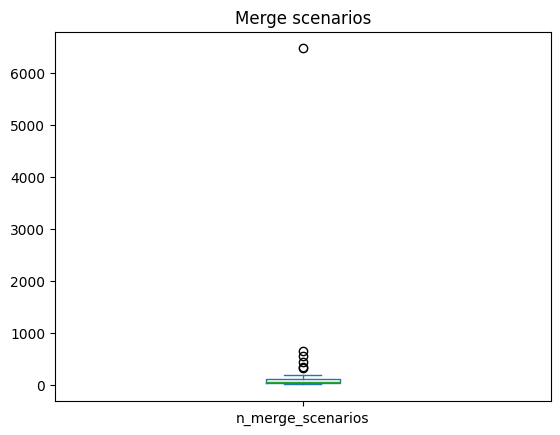

In [20]:
results['n_merge_scenarios'].plot(kind='box', title='Merge scenarios')